Script to analyze the accessibility of huts based on the difficulty and number of hiking trails reaching them.

# BASIC IDEA
Work with OSMnx an Networkx to analyze trails to huts using graphs.

For each hut:
- count number of distinct trails leading to it
- for each trail, compute the cost of arriving:
    - take start and end of trail
    - consider the DEM
    - compute time and effort of the itinerary
- compute an overall score/category of difficulty
- compare with categoria CAISAT

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, LineString
import rasterio
import random

import warnings
warnings.simplefilter("ignore")

In [3]:
# Load hut data for coordinates (in mcdm_analysis.ipynb can use merged_df)
huts_gdf = gpd.read_file('../data/huts/huts_points.geojson')
huts_gdf = huts_gdf.to_crs(epsg=32632)

# Load trails data
trails_gdf = gpd.read_file('../data/trails/Sentieri_della_SAT.shp')
trails_gdf = trails_gdf.to_crs(huts_gdf.crs)

# All trails graph
To create a OSMx graph (easy plotting and access), first I need to create 2 GeoDataFrames: one for nodes and one for edges.

In [4]:
def extract_nodes(trails_gdf):
    ''' Extract nodes (start and end points of LineStrings) ''' 

    print('Extracting nodes...')
    nodes = []
    node_to_trail = {} # id: numero

    for idx, row in trails_gdf.iterrows():
        # Get start and end points from the LineString
        start_point = Point(row.geometry.coords[0])
        end_point = Point(row.geometry.coords[-1])

        # Add to nodes list with unique ID
        nodes.append({'id': f'{idx}_start', 'geometry': start_point, 'numero': row['numero']})
        nodes.append({'id': f'{idx}_end', 'geometry': end_point, 'numero': row['numero']})

        # Add nodes' ids to dictionary for mapping to numbers
        start_node = f'{idx}_start'
        end_node = f'{idx}_end'
        trail_numero = row['numero']
        node_to_trail[start_node] = trail_numero
        node_to_trail[end_node] = trail_numero

    # Convert to GeoDataFrame
    nodes_gdf = gpd.GeoDataFrame(nodes, crs=trails_gdf.crs)
    # Drop duplicate nodes (not for now, I want to have both start and final node of each trail)
    #nodes_gdf = nodes_gdf.drop_duplicates(subset=['geometry']).reset_index(drop=True)
    
    # Add x and y columns from the geometry
    nodes_gdf['x'] = nodes_gdf.geometry.x
    nodes_gdf['y'] = nodes_gdf.geometry.y

    # Set the 'id' column as the index
    nodes_gdf.set_index('id', inplace=True)
    
    return nodes_gdf, node_to_trail


def extract_edges(trails_gdf, nodes_gdf):
    ''' Extract edges from trails_gdf with numero as an attribute '''
    
    print('Extracting edges...')
    edges = []
    for idx, row in trails_gdf.iterrows():
        # Get start and end points
        start_node = row.geometry.coords[0]
        end_node = row.geometry.coords[-1]

        # Find node indices
        start_idx = nodes_gdf[nodes_gdf.geometry == Point(start_node)].index[0]
        end_idx = nodes_gdf[nodes_gdf.geometry == Point(end_node)].index[0]

        # Create an edge with 'numero' as an attribute
        edges.append({
            'u': start_idx,   # Start node
            'v': end_idx,     # End node
            'key': 0,         # Key for handling multiple edges between same nodes
            'geometry': row.geometry,
            'numero': row['numero'],  # Add 'numero' trail identifier
            'length': row.geometry.length
        })

    # Convert to GeoDataFrame
    edges_gdf = gpd.GeoDataFrame(edges, crs=trails_gdf.crs)

    # Set MultiIndex (u, v, key)
    edges_gdf.set_index(['u', 'v', 'key'], inplace=True)
    
    print(f'Extracted {len(edges_gdf)} edges.')
    return edges_gdf


In [5]:
# # Create a dictionary mapping node IDs to trail numbers ('numero')
# node_to_trail = {}

# for idx, row in trails_gdf.iterrows():
#     # Map start and end nodes to the trail's numero
#     start_node = f'{idx}_start'
#     end_node = f'{idx}_end'
#     trail_numero = row['numero']
    
#     node_to_trail[start_node] = trail_numero
#     node_to_trail[end_node] = trail_numero


In [6]:
# Generate nodes and edges GeoDataFrames
nodes_gdf, node_to_trail = extract_nodes(trails_gdf)
edges_gdf = extract_edges(trails_gdf, nodes_gdf)

# Create the graph
G = ox.graph_from_gdfs(nodes_gdf, edges_gdf)


Extracting nodes...
Extracting edges...
Extracted 1049 edges.


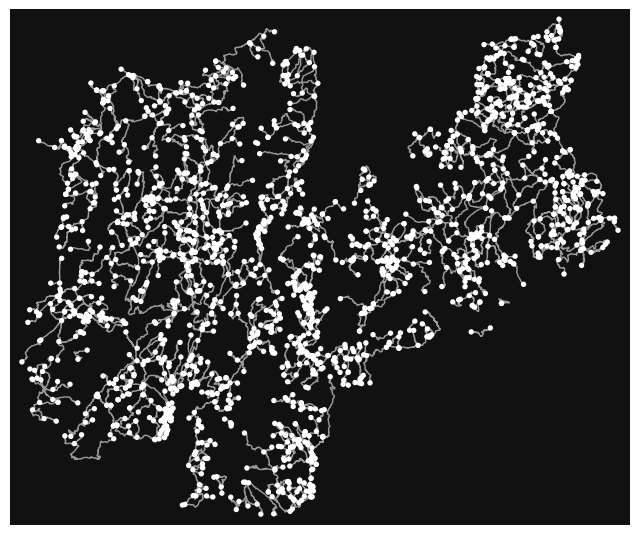

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [21]:
ox.plot_graph(G)

In [8]:
# Check node structure
for node, data in G.nodes(data=True):
    print(node, data)
    break

0_start {'numero': 'E106', 'x': 653619.719998705, 'y': 5066118.310120334}


In [9]:
# Check edge structure
for u, v, data in G.edges(data=True):
    print(u, v, data)
    break

0_start 0_end {'geometry': <LINESTRING (653619.72 5066118.31, 653633.57 5066088.25, 653645.59 5066072.7...>, 'numero': 'E106', 'length': 6514.51084652241}


Add elevation to the graph

In [10]:
def get_elevation_from_dem(nodes_gdf, dem_path='../data/terrain/clipped_dem.tif'):
    print('Extracting elevation from DEM...')

    with rasterio.open(dem_path) as dem_data:
        elevations = []

        for idx, row in nodes_gdf.iterrows():
            coord = [(row['x'], row['y'])]

            # Extract the elevation at the given coordinate
            for val in dem_data.sample(coord):
                elevation = val[0]
                elevations.append(elevation)

        nodes_gdf['elevation'] = elevations

    return nodes_gdf

In [11]:
# Extract elevation for each node
nodes_gdf = get_elevation_from_dem(nodes_gdf)

# Add the elevation as a node attribute to the graph
for idx, row in nodes_gdf.iterrows():
    G.nodes[idx]['elevation'] = row['elevation']


Extracting elevation from DEM...


# Analysis
Analyze the accessibility via hiking trails of each hut:
1. create a subgraph of the trails connected to the hut (nearest node in the graph)
2. identify trailheads in the subgraph
3. compute the shortest path to the hut from each trailhead (with length and elevation gain)

In [12]:
def find_nearest_node(huts_gdf, G):
    ''' Finds the nearest node in the graph for each hut.
    Saves node id in a new column 'nearest_node' '''
    nearest_nodes = []
    for idx, hut in huts_gdf.iterrows():
        hut_point = hut.geometry
        nearest_node = ox.distance.nearest_nodes(G, hut_point.x, hut_point.y)
        nearest_nodes.append(nearest_node)
    huts_gdf['nearest_node'] = nearest_nodes
    return huts_gdf

def compute_shortest_paths(subgraph, hut_node):
    # Find trailheads in the subgraph
    trailheads = [node for node, degree in subgraph.degree if degree == 1]
    shortest_paths = {}
    
    # Compute shortest path from each trailhead to the hut
    for trailhead in trailheads:
        if nx.has_path(subgraph, trailhead, hut_node):
            path = nx.shortest_path(subgraph, source=trailhead, target=hut_node, weight='length')
            shortest_paths[trailhead] = path
    return shortest_paths
    
def compute_path_metrics(G, path):
    '''
    Computes the length and elevation gain of a given path in the graph.
    
    Parameters:
    - G: a graph.
    - path: A list of nodes representing the shortest path.
    
    Returns:
    - A dictionary with 'length' and 'elevation_gain'.
    '''
    # Calculate the total length of the path
    length = nx.path_weight(G, path, weight='length')
    length = round(length, 2)
    
    # Calculate elevation gain
    elevation_gain = 0
    for i in range(1, len(path)):
        start_node = path[i - 1]
        end_node = path[i]
        
        # Get elevations
        start_elevation = G.nodes[start_node]['elevation']
        end_elevation = G.nodes[end_node]['elevation']
        
        # Only consider positive elevation change
        if end_elevation > start_elevation:
            elevation_gain += (end_elevation - start_elevation)
            elevation_gain = round(elevation_gain, 2)

    return {'length': length, 'elevation_gain': elevation_gain}


In [13]:
import pickle

def save_all_subgraphs(subgraphs, filename="../data/subgraphs_trails_to_huts.pkl"):
    '''
    Saves all subgraphs to a single file using pickle.
    
    Parameters:
    - subgraphs: A dictionary of subgraphs keyed by hut name.
    - filename: The filename to save the subgraphs. Default is "subgraphs.pkl".
    '''
    with open(filename, 'wb') as f:
        pickle.dump(subgraphs, f)
    print(f"Saved all subgraphs to {filename}")

In [14]:
# 1. Find nearest nodes for each hut
huts_gdf = find_nearest_node(huts_gdf, G)

# Initialize dictionaries to store the results & subgraphs
hut_metrics = {}
all_subgraphs = {}

# 2. Find connected nodes with Breadth-first search
for idx, row in huts_gdf.iterrows():
    nearest_node = row['nearest_node']
    G_undir = G.to_undirected()
    connected_nodes = nx.node_connected_component(G_undir, nearest_node)
    
    # 3. Create subgraph with connected trails
    subgraph = G_undir.subgraph(connected_nodes).copy()

    # store the subgraph in the dictionary using the hut name as the key
    hut_name = row['standard_name']  
    all_subgraphs[hut_name] = subgraph

    # 4. Compute shortest paths from trailheads to the hut
    shortest_paths = compute_shortest_paths(subgraph, nearest_node)

    # 5. Compute length and elevation gain for each path
    # Store metrics for each path
    hut_metrics[row['standard_name']] = {}
    
    for start_node, path in shortest_paths.items():
        metrics = compute_path_metrics(subgraph, path)
        hut_metrics[row['standard_name']][start_node] = {}
        hut_metrics[row['standard_name']][start_node]['path'] = path
        hut_metrics[row['standard_name']][start_node]['length'] = metrics['length']
        hut_metrics[row['standard_name']][start_node]['elevation_gain'] = metrics['elevation_gain']

# Save all subgraphs at once
save_all_subgraphs(all_subgraphs)

Saved all subgraphs to ../data/subgraphs_trails_to_huts.pkl


In [15]:
# To load the subgraphs back
filename = "../data/subgraphs_trails_to_huts.pkl"
with open(filename, 'rb') as f:
    subgraphs = pickle.load(f)


## Example results

In [16]:
huts_gdf.standard_name.unique()

array(['alpepozzavlancia', 'altissimodchiesa', 'antermoia',
       'bindesipprati', 'boccaditratnpernici', 'boè', 'carèaltodongari',
       'casarotalciola', 'cevedaleglarcher', 'ciampediè',
       'cimadastaobrentari', 'fftucketteqsella', 'finonchiofllifilzi',
       'grostèggraffer', 'mandroncittàditrento', 'montecalinosanpietro',
       'monzonittaramelli', 'paludei', 'peller', 'rodadivael',
       'rosettagpedrotti', 'saentsdorigoni', 'setteselle', 'stavelfdenza',
       'stivopmarchetti', 'tosaetpedrotti', 'vaiolet',
       'valdambiezsagostini', 'valdamolagsegantini', 'valdifumo',
       'velomadonna', 'vioz', 'xiiapostoliflligarbari'], dtype=object)

In [26]:
hut_name = 'antermoia'
res = hut_metrics[hut_name]
res

{'390_start': {'path': ['390_start', '382_start', '382_end', '441_end'],
  'length': 12241.79,
  'elevation_gain': 1136.68},
 '413_end': {'path': ['413_end',
   '413_start',
   '382_start',
   '382_end',
   '441_end'],
  'length': 19156.08,
  'elevation_gain': 655.27},
 '424_end': {'path': ['424_end',
   '413_start',
   '382_start',
   '382_end',
   '441_end'],
  'length': 18430.46,
  'elevation_gain': 12843.1},
 '319_end': {'path': ['319_end', '319_start', '441_end'],
  'length': 6504.36,
  'elevation_gain': 12491.04},
 '442_start': {'path': ['442_start', '441_end'],
  'length': 6385.57,
  'elevation_gain': 1116.16},
 '384_start': {'path': ['384_start', '382_start', '382_end', '441_end'],
  'length': 12937.68,
  'elevation_gain': 1217.92},
 '414_start': {'path': ['414_start',
   '413_start',
   '382_start',
   '382_end',
   '441_end'],
  'length': 16855.07,
  'elevation_gain': 1083.51}}

In [27]:
print(f"Found {len(res)} paths to hut {hut_name}.")
for start_node, metrics in res.items():
    path_numbers = [node_to_trail[node] for node in metrics['path']]
    print(f"\nShortest path from {node_to_trail[start_node]}: {path_numbers}")
    print(f"Length: {metrics['length']} m")
    print(f"Elevation gain: {metrics['elevation_gain']} m")
    

Found 7 paths to hut antermoia.

Shortest path from E544: ['E544', 'E540', 'E540', 'E584']
Length: 12241.79 m
Elevation gain: 1136.68 m

Shortest path from E541: ['E541', 'E541', 'E540', 'E540', 'E584']
Length: 19156.08 m
Elevation gain: 655.27 m

Shortest path from E549: ['E549', 'E541', 'E540', 'E540', 'E584']
Length: 18430.46 m
Elevation gain: 12843.1 m

Shortest path from E542: ['E542', 'E542', 'E584']
Length: 6504.36 m
Elevation gain: 12491.04 m

Shortest path from E580: ['E580', 'E584']
Length: 6385.57 m
Elevation gain: 1116.16 m

Shortest path from E543: ['E543', 'E540', 'E540', 'E584']
Length: 12937.68 m
Elevation gain: 1217.92 m

Shortest path from E548: ['E548', 'E541', 'E540', 'E540', 'E584']
Length: 16855.07 m
Elevation gain: 1083.51 m


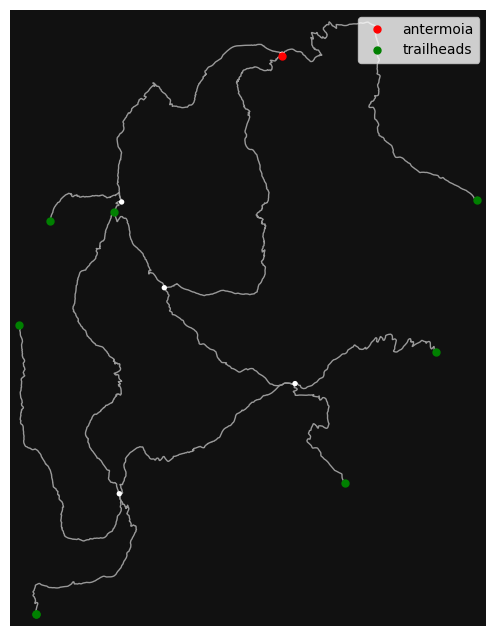

In [28]:
# Plot subgraph with hut
hut_geom = huts_gdf[huts_gdf['standard_name'] == hut_name]['geometry'].values[0]
subgraph = all_subgraphs[hut_name]

fig, ax = ox.plot_graph(subgraph, show=False, close=False)
# plot hut in red
ax.plot(hut_geom.x, hut_geom.y, 'ro', markersize=5, label=hut_name)
# plot trailheads in green
trailheads = [key for key,val in res.items()]
for trailhead in trailheads:
    ax.plot(subgraph.nodes[trailhead]['x'], subgraph.nodes[trailhead]['y'], 'go', markersize=5)
    # at last, add trailheads label
    if trailhead == trailheads[-1]:
        ax.plot(subgraph.nodes[trailhead]['x'], subgraph.nodes[trailhead]['y'], 'go', markersize=5, label=f'trailheads')

plt.legend()
